In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import OneHotEncoder


# Data loading

In [2]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [3]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

In [4]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = 2*(X / 255) - 1 #Normalize to -1,1
# meanX = np.mean(X, 0)
# stdX = np.std(X, 0) 
# X = (X - meanX)/stdX # Mean removal and variance scaling

y = dataset0.target
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

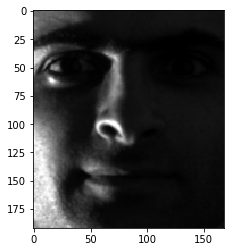

In [5]:
plt.imshow(X[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

# Optimal Encoding

In [6]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [7]:
n_in = X.shape[-1]
n_cts = 2
n_categorical = 1

depth = 2
widths = [300, 300]

In [8]:
encoder = MLP(n_in, 2*n_cts + n_categorical, depth, widths)
decoder = MLP(n_cts + n_categorical, n_in, depth, widths)

In [9]:
oe = OptimalEncoding(encoder, decoder, n_cts, n_categorical)

100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


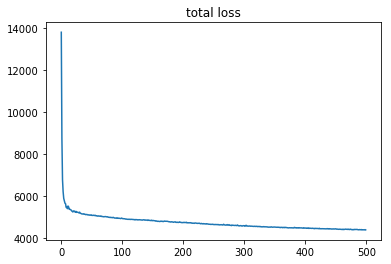

In [10]:
oe.train(X_train, optimal = False, epochs=500, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [11]:
zhat = oe.encode(X_train)

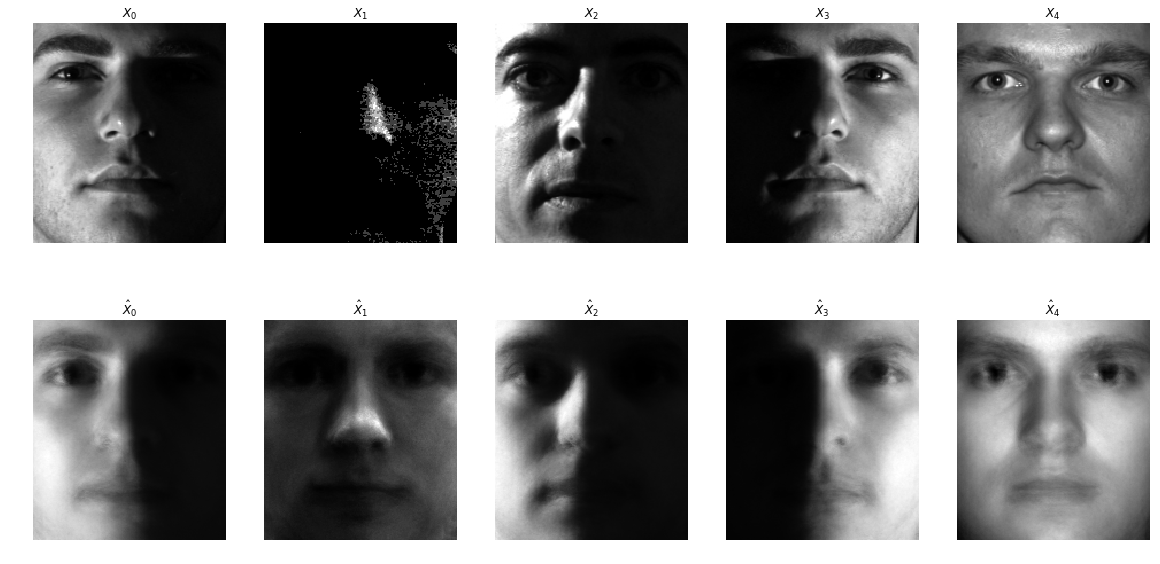

In [12]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [13]:
np.mean(zhat[:,-n_categorical:], 0)

array([ 1.], dtype=float32)

In [14]:
zhat = oe.encode(X_test)

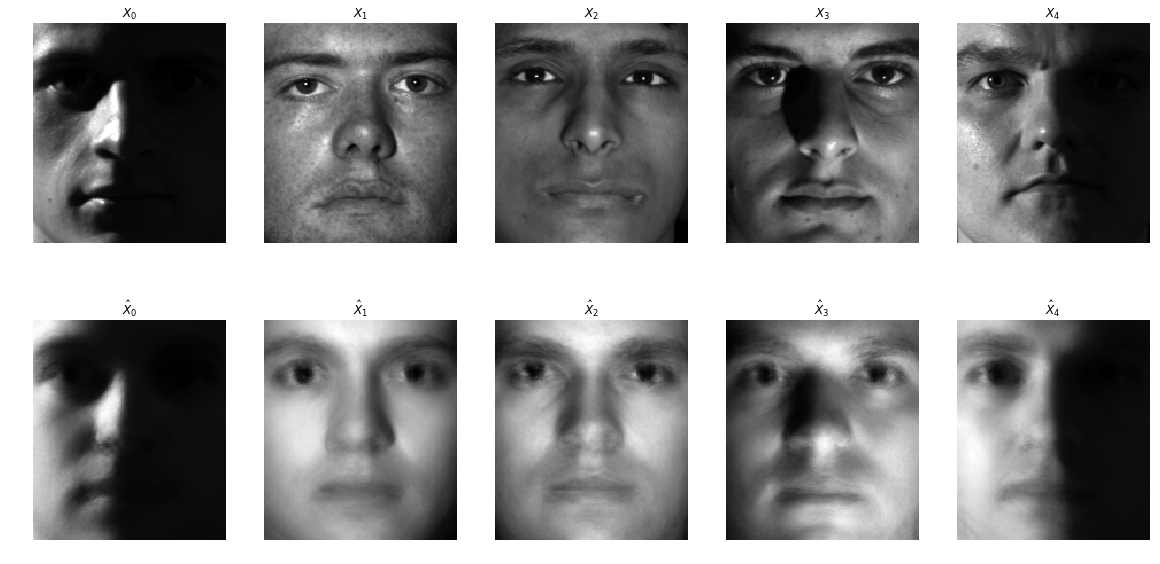

In [15]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [16]:
np.mean(zhat[:,-n_categorical:], 0)

array([ 1.], dtype=float32)

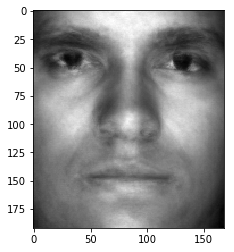

In [17]:
Xgen = oe.sample(1)
plt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

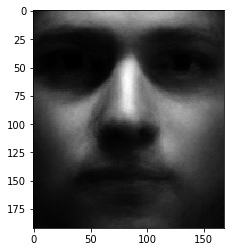

In [18]:
z_cts = np.random.normal(size=(1, n_cts))
if n_categorical > 0:
    onehot = OneHotEncoder(n_values=n_categorical, sparse=False)
    z_categorical = onehot.fit_transform(np.random.randint(n_categorical, size=(1,1)))
    z = np.hstack((z_cts, z_categorical))
else: z = z_cts
Xgen = oe.decode(z)
plt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)

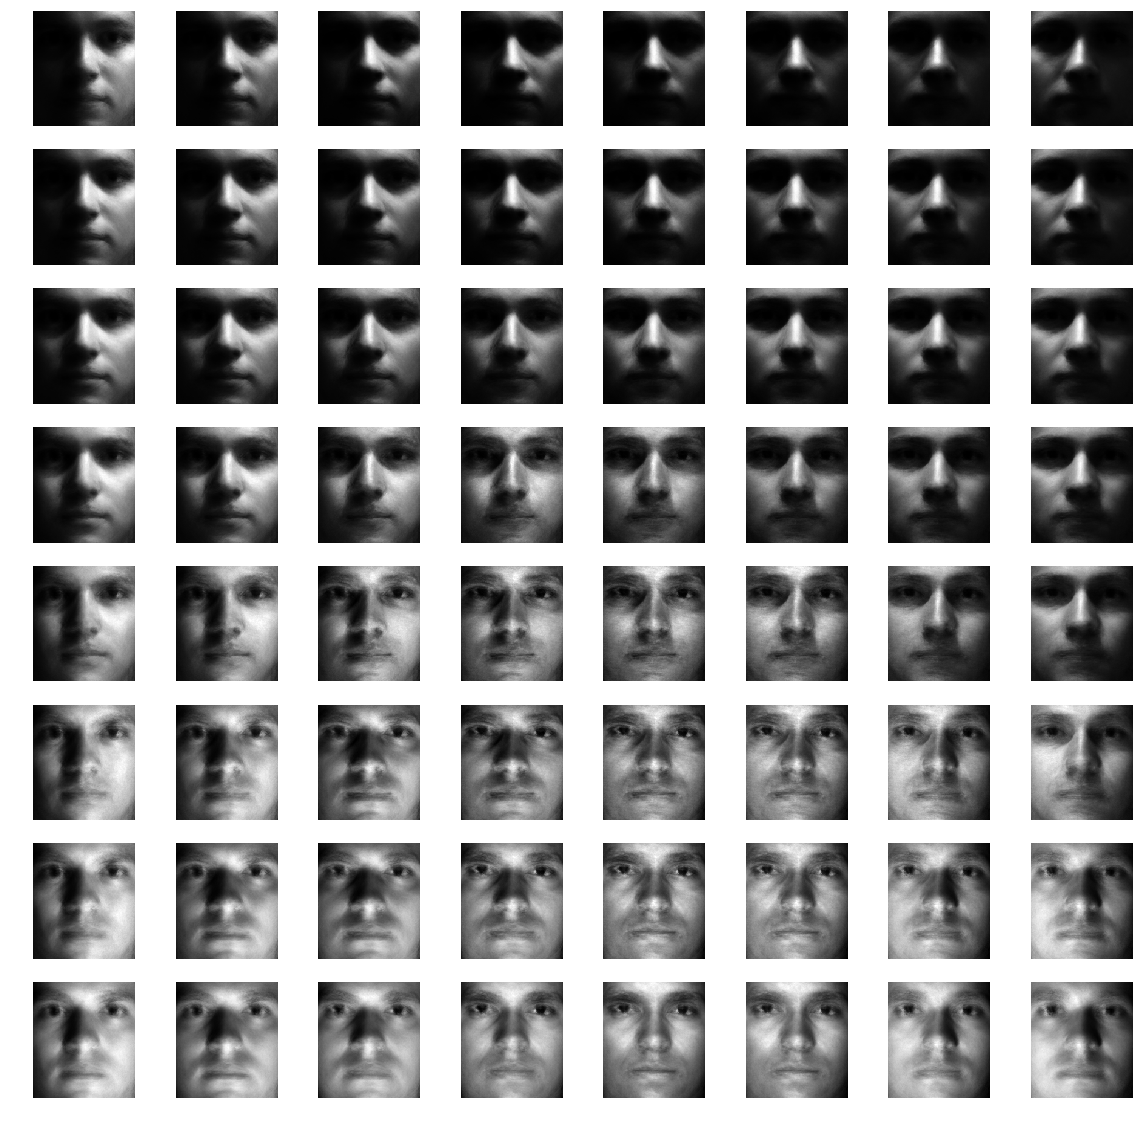

In [19]:
vals = np.arange(-2,2,.5)
n = len(vals)

fig, ax = plt.subplots(figsize = (20,20), nrows=n, ncols=n)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        z_aug = np.copy(z)
        z_aug[:,0] = vals[i]
        z_aug[:,1] = vals[j]
        Xgen = oe.decode(z_aug)
        subplt.imshow(Xgen[0].reshape(shapeX[1],shapeX[2]), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()